In [1]:
import os
import numpy as np
import pandas as pd

from pathlib import Path

from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

from collections import Counter

In [2]:
bench_result = Path("benchmark_model_consensus")
os.listdir(bench_result)

['acf', 'chembl', 'molnet']

In [3]:
bench_folder = os.path.join(bench_result, "chembl")

In [4]:
def calc_accuracy(y_true, y_pred, metric='mae'):
    if metric == 'mae':
        acc = mean_absolute_error(y_true, y_pred)
    elif metric == 'r2':
        acc = r2_score(y_true, y_pred)
    elif metric == 'rmse':
        acc = root_mean_squared_error(y_true, y_pred)

    return acc

In [5]:
metric = "r2"

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_model_boxplots(df: pd.DataFrame, metric_name='R²', higher_is_better=True):
    """
    Plots boxplots with error for each model's performance across datasets using seaborn.
    
    Parameters:
        df (pd.DataFrame): Rows = datasets, Columns = models, Values = performance metric.
        metric_name (str): Name of the metric to label the y-axis (e.g., 'R²', 'RMSE').
        higher_is_better (bool): Optional – used to annotate the plot, doesn't affect visuals.
    """
    # Melt the DataFrame into long format for seaborn
    melted = df.reset_index(drop=True).melt(var_name='Model', value_name=metric_name)
    
    # Set style
    sns.set(style="whitegrid")

    # Create the boxplot
    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(data=melted, x='Model', y=metric_name, showmeans=True,
                     meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"})
    
    # Optional: Annotate y-axis
    direction = "Higher is better" if higher_is_better else "Lower is better"
    plt.title(f'Model Performance ({metric_name}) - {direction}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def compute_cumulative_top_k(df: pd.DataFrame, k: int = None, higher_is_better: bool = True) -> pd.DataFrame:
    """
    Compute how often each model was in the Top-k positions, cumulatively, with options for k and higher_is_better.
    
    Parameters:
        df (pd.DataFrame): DataFrame where each column is a model, 
                           each row is a dataset, and values are regression metrics (e.g., R²).
        k (int, optional): The number of top positions to count (default is None, which counts up to all available models).
        higher_is_better (bool, optional): If True, assumes higher values are better (default is True).
    
    Returns:
        pd.DataFrame: A DataFrame showing cumulative Top-k counts per model.
    """
    # Rank models in descending or ascending order based on 'higher_is_better' parameter
    ranks = df.rank(axis=1, method='min', ascending=not higher_is_better)
    
    # Set k to the number of models if None
    if k is None:
        k = len(df.columns)
    
    # Prepare result container
    top_k_counts = pd.DataFrame(index=df.columns)
    
    # Calculate cumulative counts for Top-1, Top-2, ..., Top-k
    for i in range(1, k + 1):
        in_top_k = (ranks <= i).sum()
        top_k_counts[f'Top-{i}'] = in_top_k
    
    # Return the DataFrame with cumulative top-k counts per model
    return top_k_counts

def compare_two_models(df: pd.DataFrame, model_1: str, model_2: str, higher_is_better=True) -> dict:
    """
    Compares two models across datasets and counts how often each is better.
    
    Parameters:
        df (pd.DataFrame): Rows = datasets, Columns = models.
        model_1 (str): First model name.
        model_2 (str): Second model name.
        higher_is_better (bool): Whether higher values are better (e.g., RÂ²) or worse (e.g., RMSE).
        
    Returns:
        dict: Counts of how often model_1 wins, model_2 wins, and ties.
    """
    assert model_1 in df.columns and model_2 in df.columns, "Both model names must be in the DataFrame."

    m1_vals = df[model_1]
    m2_vals = df[model_2]
    
    if higher_is_better:
        m1_better = (m1_vals > m2_vals).sum()
        m2_better = (m2_vals > m1_vals).sum()
    else:
        m1_better = (m1_vals < m2_vals).sum()
        m2_better = (m2_vals < m1_vals).sum()

    ties = (m1_vals == m2_vals).sum()

    return {
        f"{model_1} better": m1_better.item(),
        f"{model_2} better": m2_better.item(),
        "Ties": ties.item()
    }

### 1. Mean/median prediction accuracy

### TODO: dirty code -> clean up

In [8]:
tmp = []
for bench_dataset in os.listdir(bench_folder):

    # read predictions
    train_df = pd.read_csv(os.path.join(bench_folder, bench_dataset, "train.csv"))
    test_df = pd.read_csv(os.path.join(bench_folder, bench_dataset, "test.csv"))
    
    # calc accuracy metric for each consensus/stacking method for test set predictions
    result_test = test_df.drop(columns='Y_TRUE').apply(lambda col: calc_accuracy(test_df['Y_TRUE'], col, metric=metric))

    # get rid of scientific nitation like -1.422665e+09 for stable mean calcualtion
    # ATTENTION! if for example r2 = -12435t5.2 it will be converted to 0 for the method -> it is nit completely correct
    if metric == "r2": # conditions for TODO other metrics (ame, rmse)
        result_test = result_test.where(result_test > 10 ** -3, other=0)
    
    tmp.append(result_test)

# calc mean accuracy #TODO choose mean or median
result_mean = sum(tmp) / len(tmp)
result_mean = result_mean.sort_values(ascending=False).to_frame()
result_mean.round(2)

,0
Genetic,0.67
Systematic,0.65
Best,0.65
Stack_test_RandomForestRegressor(),0.63
Stack_test_KNeighborsRegressor(),0.52
Stack_test_Ridge(),0.50
Stack_test_LinearRegression(),0.49
Random,0.47
Stack_test_SVR(),0.40
All,0.37


In [11]:
res_df = pd.DataFrame(tmp)

### 2. Prediction accuracy boxplot

### TODO: implement the boxplot of accuracy distribution over datasets

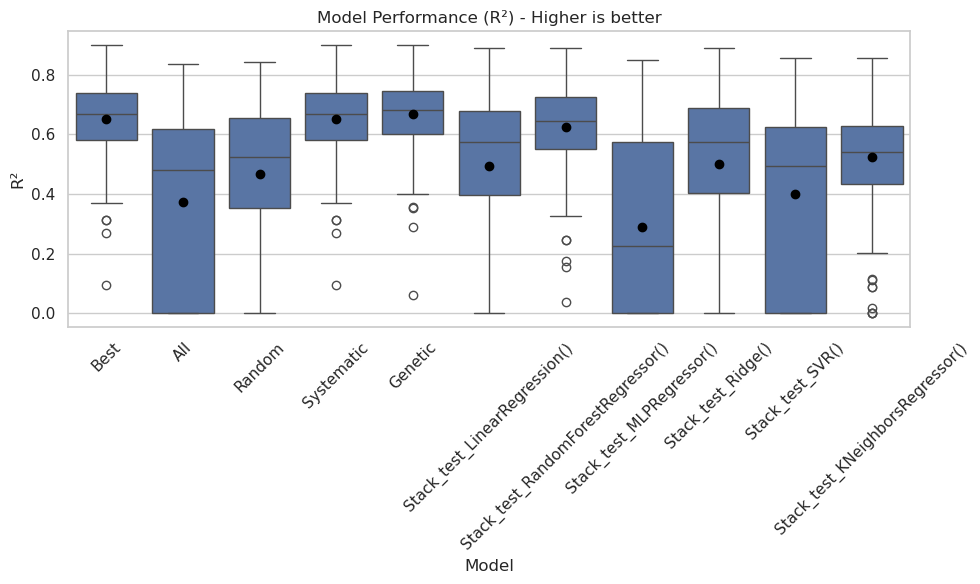

In [12]:
plot_model_boxplots(res_df, metric_name='R²', higher_is_better=True)

### 3. Top-N statistics

### TODO: implement the choice of N (Top-1, Top-2, Top-5, etc)

In [18]:
pair_df = compute_cumulative_top_k(res_df, k=3, higher_is_better=True)
pair_df.sort_values(by="Top-1", ascending=False)

,Top-1,Top-2,Top-3
Genetic,141,151,181
Systematic,29,138,169
Best,29,138,169
Stack_test_RandomForestRegressor(),21,40,52
Stack_test_Ridge(),6,19,26
Stack_test_LinearRegression(),2,12,23
Stack_test_MLPRegressor(),1,1,1
Random,0,1,1
All,0,4,4
Stack_test_SVR(),0,4,4


### 4. Pair accuracy comparison
### TODO: this is a metric from JCIM paper on MIL

In [21]:
compare_two_models(res_df, model_1="Systematic", model_2="Genetic", higher_is_better=True)

{'Systematic better': 38, 'Genetic better': 162, 'Ties': 0}

### 5. CI Diagram from JCIM paper on MIL
### TODO: DZ -> I will find the code for building this diagram

In [ ]:
# to be implemented